# Coursera Courses Data Analysis

## Imports

### Python modules

In [37]:
import subprocess

import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import probplot, spearmanr

### Downloading compressed Coursera Courses dataset

In [38]:
subprocess.run(
    "kaggle datasets download -d siddharthm1698/coursera-course-dataset",
    shell=True,
    check=True,
)

Dataset URL: https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset
License(s): GPL-2.0
coursera-course-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


CompletedProcess(args='kaggle datasets download -d siddharthm1698/coursera-course-dataset', returncode=0)

#### Extracting compressed Coursera Courses dataset

In [39]:
ZIPPED_DATASET_OF_COURSERA_COURSES = "coursera-course-dataset.zip"

with zipfile.ZipFile(ZIPPED_DATASET_OF_COURSERA_COURSES, "r") as zip_ref:
    zip_ref.extractall(".")
    print("Zipped files extraction has been successful.")

Zipped files extraction has been successful.


### Importing Coursera Courses dataset into memory as a pandas DataFrame

In [40]:
COURSERA_COURSES_DATASET = "coursea_data.csv"

coursera_courses_df = pd.read_csv(
    COURSERA_COURSES_DATASET, sep=",", index_col=0, encoding="utf-8", header=0
)

coursera_courses_df = coursera_courses_df.infer_objects()

#### Dataframe check

In [41]:
coursera_courses_df.head()

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner...,(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal...,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


* Will need to modify "course_students_enrolled" feature values (e.g. 12k, 3m) to integer values.

## Data Wrangling

### Data exploration

#### Checking dataframe info

In [42]:
coursera_courses_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 134 to 163
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_title              891 non-null    object 
 1   course_organization       891 non-null    object 
 2   course_Certificate_type   891 non-null    object 
 3   course_rating             891 non-null    float64
 4   course_difficulty         891 non-null    object 
 5   course_students_enrolled  891 non-null    object 
dtypes: float64(1), object(5)
memory usage: 48.7+ KB


* Dataframe does not have any empty values.
* Investigate data ambiguity for features with 'object' type.
* Lowercase 'course_Certificate_type' feature name.
* Change "course_certificate_type", "course_difficulty" features data type to category.

#### Checking data uniqueness

In [43]:
coursera_courses_df.apply(lambda x: x.nunique())

course_title                888
course_organization         154
course_Certificate_type       3
course_rating                14
course_difficulty             4
course_students_enrolled    205
dtype: int64

#### Checking duplicates by "course_title"

In [44]:
coursera_courses_df[coursera_courses_df["course_title"].duplicated(keep=False)]

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
756,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41k
205,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54k
181,Machine Learning,University of Washington,SPECIALIZATION,4.6,Intermediate,290k
6,Machine Learning,Stanford University,COURSE,4.9,Mixed,3.2m
241,Marketing Digital,Universidade de São Paulo,COURSE,4.8,Beginner,81k
325,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,Beginner,39k


* There are three duplicates by "course_title", however other feature values differs in these samples. No action should be taken to remove duplicates.

#### Checking unique "course_organization" values

In [45]:
coursera_courses_df["course_organization"].unique()[0:10]

array(['(ISC)²', 'University of Pennsylvania', 'Johns Hopkins University',
       'Yale University', 'Indian School of Business',
       'University at Buffalo', 'deeplearning.ai', 'IBM',
       'Amazon Web Services', 'University of Toronto'], dtype=object)

Should try to create value groups of course organizations. Most of organizations are universities, but there are 'IBM', 'Amazon', and possibly other types of organizations that would be interesting too compare against universities.

### Data Transformation and Feature Engineering

#### Lowercasing names of features 

In [46]:
coursera_courses_df.columns = coursera_courses_df.columns.str.lower()

#### Lowercasing "course_certificate_type" values

In [47]:
coursera_courses_df["course_certificate_type"] = (
    coursera_courses_df["course_certificate_type"].str.lower().str.title()
)

#### Categorizing "course_certificate_type", "course_difficulty" features

In [48]:
coursera_courses_df["course_certificate_type"] = coursera_courses_df[
    "course_certificate_type"
].astype("category")
coursera_courses_df["course_difficulty"] = coursera_courses_df[
    "course_difficulty"
].astype("category")

#### Converting "course_students_enrolled" feature values to integer values

In [49]:
def convert_suffix_to_number(x):
    if "k" in str(x):
        return eval(x.replace("k", "*1e3"))
    if "m" in str(x):
        return eval(x.replace("m", "*1e6"))
    else:
        return float(x)


coursera_courses_df["course_students_enrolled"] = (
    coursera_courses_df["course_students_enrolled"].apply(convert_suffix_to_number)
).astype(int)

#### Grouping "course_organization" feature

<Axes: xlabel='course_organization_type'>

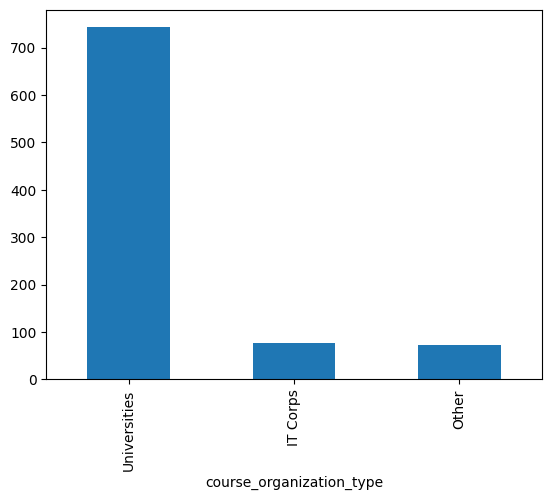

In [50]:
def contains(string: str, substrings: list) -> bool:
    return any(substring in string for substring in substrings)


def categorize_course_organization(x: str):
    x = x.lower()
    if contains(
        x,
        [
            "univers",
            "school",
            "college",
            "institut",
            "technol",
            "tecnol",
            "polytech",
            "hec paris",
            "paristech",
        ],
    ):
        return "Universities"
    if contains(
        x,
        ["google", "amazon", "facebook", "ibm", "microsoft", "apple", "netflix", "sas"],
    ):
        return "IT Corps"
    return "Other"


coursera_courses_df["course_organization_type"] = (
    coursera_courses_df["course_organization"]
    .apply(categorize_course_organization)
    .astype("category")
)

coursera_courses_df["course_organization_type"].value_counts().plot.bar()

#### Ordering groups of categorical features

In [51]:
difficulty_order = ["Beginner", "Intermediate", "Advanced", "Mixed"]
certificate_order = ["Course", "Specialization", "Professional Certificate"]
organization_type_order = ["Universities", "IT Corps", "Other"]


coursera_courses_df["course_difficulty"] = pd.Categorical(
    coursera_courses_df["course_difficulty"], categories=difficulty_order
)
coursera_courses_df["course_certificate_type"] = pd.Categorical(
    coursera_courses_df["course_certificate_type"],
    categories=certificate_order,
)
coursera_courses_df["course_organization_type"] = pd.Categorical(
    coursera_courses_df["course_organization_type"],
    categories=organization_type_order,
)

Ordering makes sense only for the "Course Difficulty" groups, as they can be interpreted as ranks (i.e., "Beginner" -> "Intermediate" -> "Advanced"), although there is also a "Mixed" group. This ordering is applied solely for better data visualization. For the other two features, the group on the left will have the highest frequency, with the frequency decreasing as you move to the right.

#### Adding additional feature with reduced group number of "course_rating"

It will be hard to display and interpret 14 distinct values as groups in the plot.

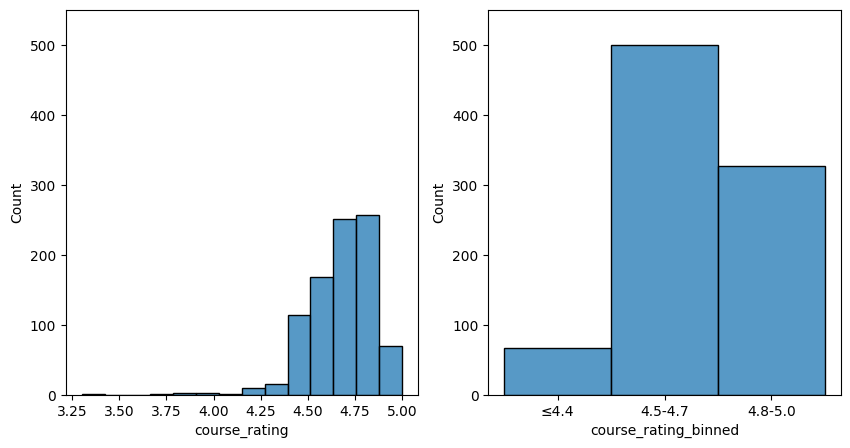

In [52]:
coursera_courses_df["course_rating_binned"] = pd.cut(
    coursera_courses_df["course_rating"],
    bins=[0, 4.4, 4.7, 5.0],
    labels=["≤4.4", "4.5-4.7", "4.8-5.0"],
).astype("category")


fig, axis = plt.subplots(1, 2, figsize=(10, 5))

columns = ["course_rating", "course_rating_binned"]

for idx, column in enumerate(columns):
    sns.histplot(
        data=coursera_courses_df,
        x=column,
        ax=axis[idx],
        bins=coursera_courses_df[column].nunique(),
    )
    axis[idx].set_ylim(0, 550)

I decided to reduce the 'Course Ratings' categories from 14 to 3. Determining the best intervals was challenging, so I experimented with different sizes. Ultimately, I chose interval ranges that, in my opinion, best indicate the quality of the course, though I still tried to keep the histograms similar.

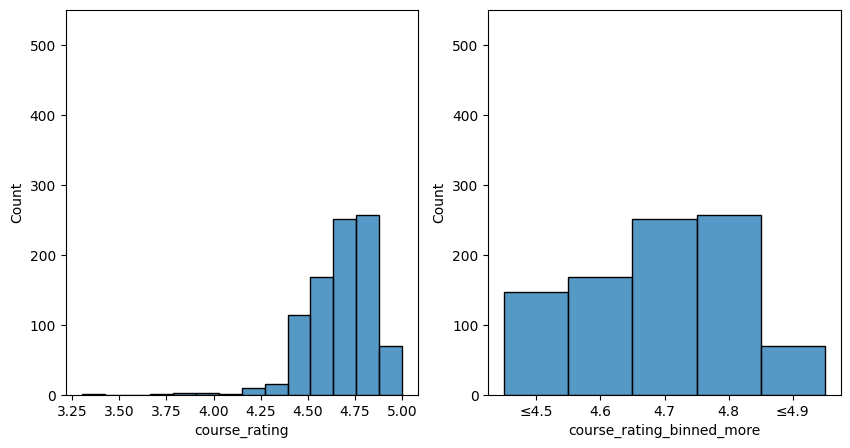

In [53]:
coursera_courses_df["course_rating_binned_more"] = pd.cut(
    coursera_courses_df["course_rating"],
    bins=[0, 4.5, 4.6, 4.7, 4.8, 5.0],
    labels=["≤4.5", "4.6", "4.7", "4.8", "≤4.9"],
).astype("category")


fig, axis = plt.subplots(1, 2, figsize=(10, 5))

columns = ["course_rating", "course_rating_binned_more"]

for idx, column in enumerate(columns):
    sns.histplot(
        data=coursera_courses_df,
        x=column,
        ax=axis[idx],
        bins=coursera_courses_df[column].nunique(),
    )
    axis[idx].set_ylim(0, 550)

Afterwards I created one more feature to categorize the course rating into 5 bins. In this feature the distribution of range values are more equal then in the other created feature.

## Exploratory Data Analysis

### Quick overview of best and worst courses by title

#### Best rated courses

In [54]:
coursera_courses_df[
    coursera_courses_df["course_rating"] == coursera_courses_df["course_rating"].max()
][:]

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled,course_organization_type,course_rating_binned,course_rating_binned_more
789,El Abogado del Futuro: Legaltech y la Transfor...,Universidad Austral,Course,5.0,Beginner,1500,Universities,4.8-5.0,≤4.9
401,Infectious Disease Modelling,Imperial College London,Specialization,5.0,Intermediate,1600,Universities,4.8-5.0,≤4.9


#### Worst rated courses

In [55]:
coursera_courses_df[
    coursera_courses_df["course_rating"] == coursera_courses_df["course_rating"].min()
][:]

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled,course_organization_type,course_rating_binned,course_rating_binned_more
767,How To Create a Website in a Weekend! (Project...,The State University of New York,Course,3.3,Mixed,140000,Universities,≤4.4,≤4.5


#### Most enrolled courses

In [56]:
coursera_courses_df[
    coursera_courses_df["course_students_enrolled"]
    == coursera_courses_df["course_students_enrolled"].max()
][:]

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled,course_organization_type,course_rating_binned,course_rating_binned_more
6,Machine Learning,Stanford University,Course,4.9,Mixed,3200000,Universities,4.8-5.0,≤4.9


#### Least enrolled courses

In [57]:
coursera_courses_df[
    coursera_courses_df["course_students_enrolled"]
    == coursera_courses_df["course_students_enrolled"].min()
][:]

,course_title,course_organization,course_certificate_type,course_rating,course_difficulty,course_students_enrolled,course_organization_type,course_rating_binned,course_rating_binned_more
789,El Abogado del Futuro: Legaltech y la Transfor...,Universidad Austral,Course,5.0,Beginner,1500,Universities,4.8-5.0,≤4.9


### Distributions of categorical features

To understand the data composition and the role and patterns of categorical features, it is crucial to examine their distribution. This step is essential for conducting further analysis and extracting valuable insights from categorical data.

In [58]:
CATEGORICAL_FEATURES = (
    "course_difficulty",
    "course_certificate_type",
    "course_organization_type",
)

TUPLE_LENGTH_OF_CATEGORICAL_FEATURES: int = len(CATEGORICAL_FEATURES)

GROUPS_ORDER_OF_COURSE_RATINGS = ("4.8-5.0", "4.5-4.7", "≤4.4")
GROUPS_PALETTE_OF_COURSE_RATINGS = ("#97e846", "#e8e846", "#e89746")

GROUPS_ORDER_OF_COURSE_RATINGS_MORE_CATEGORIES = (
    "≥4.9",
    "4.8",
    "4.7",
    "4.6",
    "≤4.5",
)
GROUPS_PALETTE_OF_COURSE_RATINGS_MORE_CATEGORIES = (
    "#97e846",
    "#bbd42f",
    "#d3bf2b",
    "#e2aa36",
    "#e89746",
)

#### Group distribution of categorical features with 'Course Rating' variance

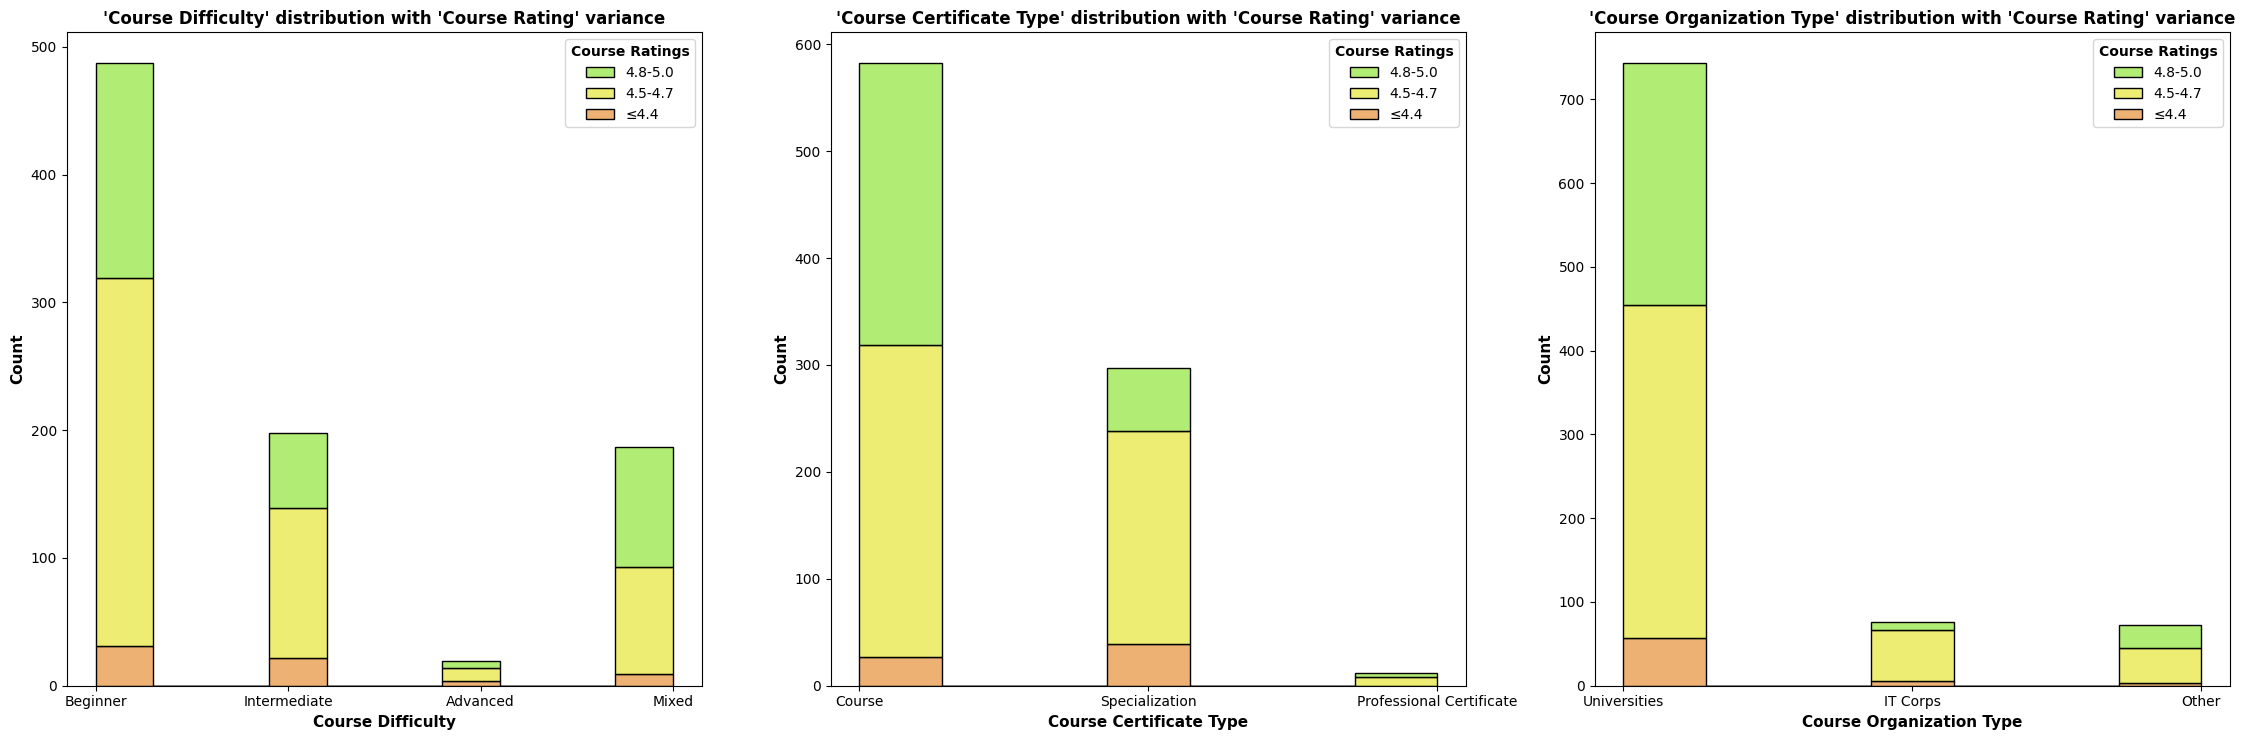

In [59]:
fig, axes = plt.subplots(
    1,
    TUPLE_LENGTH_OF_CATEGORICAL_FEATURES,
    figsize=(TUPLE_LENGTH_OF_CATEGORICAL_FEATURES * 7.5, 7.5),
)

for ax, feature in zip(axes, CATEGORICAL_FEATURES):
    feature_title = feature.replace("_", " ").title()

    histplot = sns.histplot(
        data=coursera_courses_df,
        x=feature,
        hue="course_rating_binned",
        hue_order=GROUPS_ORDER_OF_COURSE_RATINGS,
        binwidth=0.3,
        discrete=False,
        palette=GROUPS_PALETTE_OF_COURSE_RATINGS,
        multiple="stack",
        ax=ax,
    )

    histplot.set_title(
        f"'{feature_title}' distribution with 'Course Rating' variance",
        fontsize=12,
        fontweight="bold",
    )
    histplot.set_xlabel(feature_title, fontsize=11, fontweight="bold")
    histplot.set_ylabel("Count", fontsize=11, fontweight="bold")
    histplot.legend_.set_title(
        title="Course Ratings", prop={"size": 10, "weight": "bold"}
    )

fig.tight_layout()

**Histogram data overview:**
* Course Difficulty: Most courses are designed for beginners, with "Beginner" being the largest group. "Intermediate" and "Mixed" difficulty levels have similar counts, while "Advanced" courses are the least common.

* Course Certificate Type: The majority of courses offer a "Course" certificate, with "Specialization" certificates being the next most common. "Professional Certificate" courses are the least frequent and form a very small group.

* Course Organization Type: "Universities" are the predominant providers of courses, significantly outnumbering "IT Corps" and "Other" organizations, which have similar counts.

* Course Ratings: The distribution of course ratings does not show any visible outliers in the histogram. Lower ratings are rare, mid-range ratings are the most frequent, and high ratings are much more common than low ratings. Note that the course ratings have been binned manually.


The majority of online courses are designed for beginners and are provided by universities. Most of these courses are categorized as "courses" probably because they include many subcategories of other types. The distributions align well with real-world expectations.

#### Group distribution of categorical features with 'Course Rating' variance (more bins)

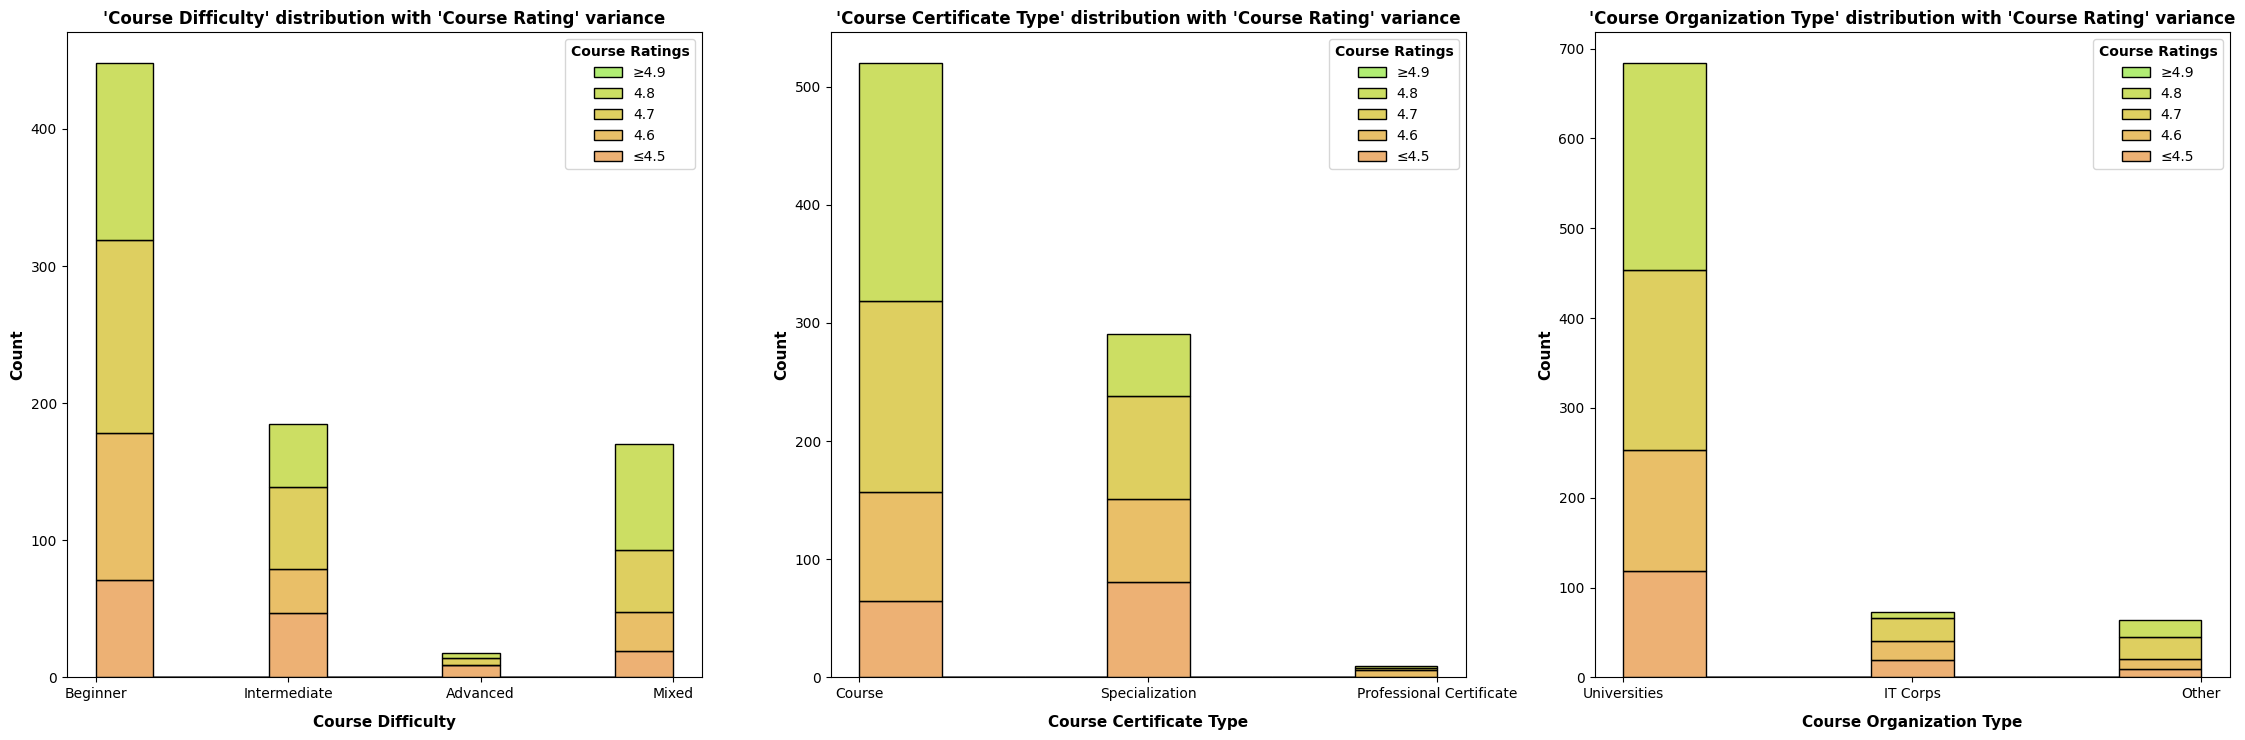

In [60]:
fig, axes = plt.subplots(
    1,
    TUPLE_LENGTH_OF_CATEGORICAL_FEATURES,
    figsize=(TUPLE_LENGTH_OF_CATEGORICAL_FEATURES * 7.5, 7.5),
)

for ax, feature in zip(axes, CATEGORICAL_FEATURES):
    feature_title = feature.replace("_", " ").title()

    histplot = sns.histplot(
        data=coursera_courses_df,
        x=feature,
        hue="course_rating_binned_more",
        hue_order=GROUPS_ORDER_OF_COURSE_RATINGS_MORE_CATEGORIES,
        binwidth=0.3,
        discrete=False,
        palette=GROUPS_PALETTE_OF_COURSE_RATINGS_MORE_CATEGORIES,
        multiple="stack",
        ax=ax,
    )

    histplot.set_title(
        f"'{feature_title}' distribution with 'Course Rating' variance",
        fontsize=12,
        fontweight="bold",
    )
    histplot.set_xlabel(feature_title, fontsize=11, fontweight="bold", labelpad=10)
    histplot.set_ylabel("Count", fontsize=11, fontweight="bold")
    histplot.legend_.set_title(
        title="Course Ratings", prop={"size": 10, "weight": "bold"}
    )

fig.tight_layout()

Compared to the 'Course Rating Binned' feature with only three bins, the distribution of this histogram remains largely unchanged, with 4.7 and 4.8 ratings dominating. However, I decided to continue further analysis with the 'Course Rating Binned' feature (3 bins) as it simplifies the plots and, for me, makes more sense as categories.

#### Distribution of "Course Students Enrolled" by categorical feature

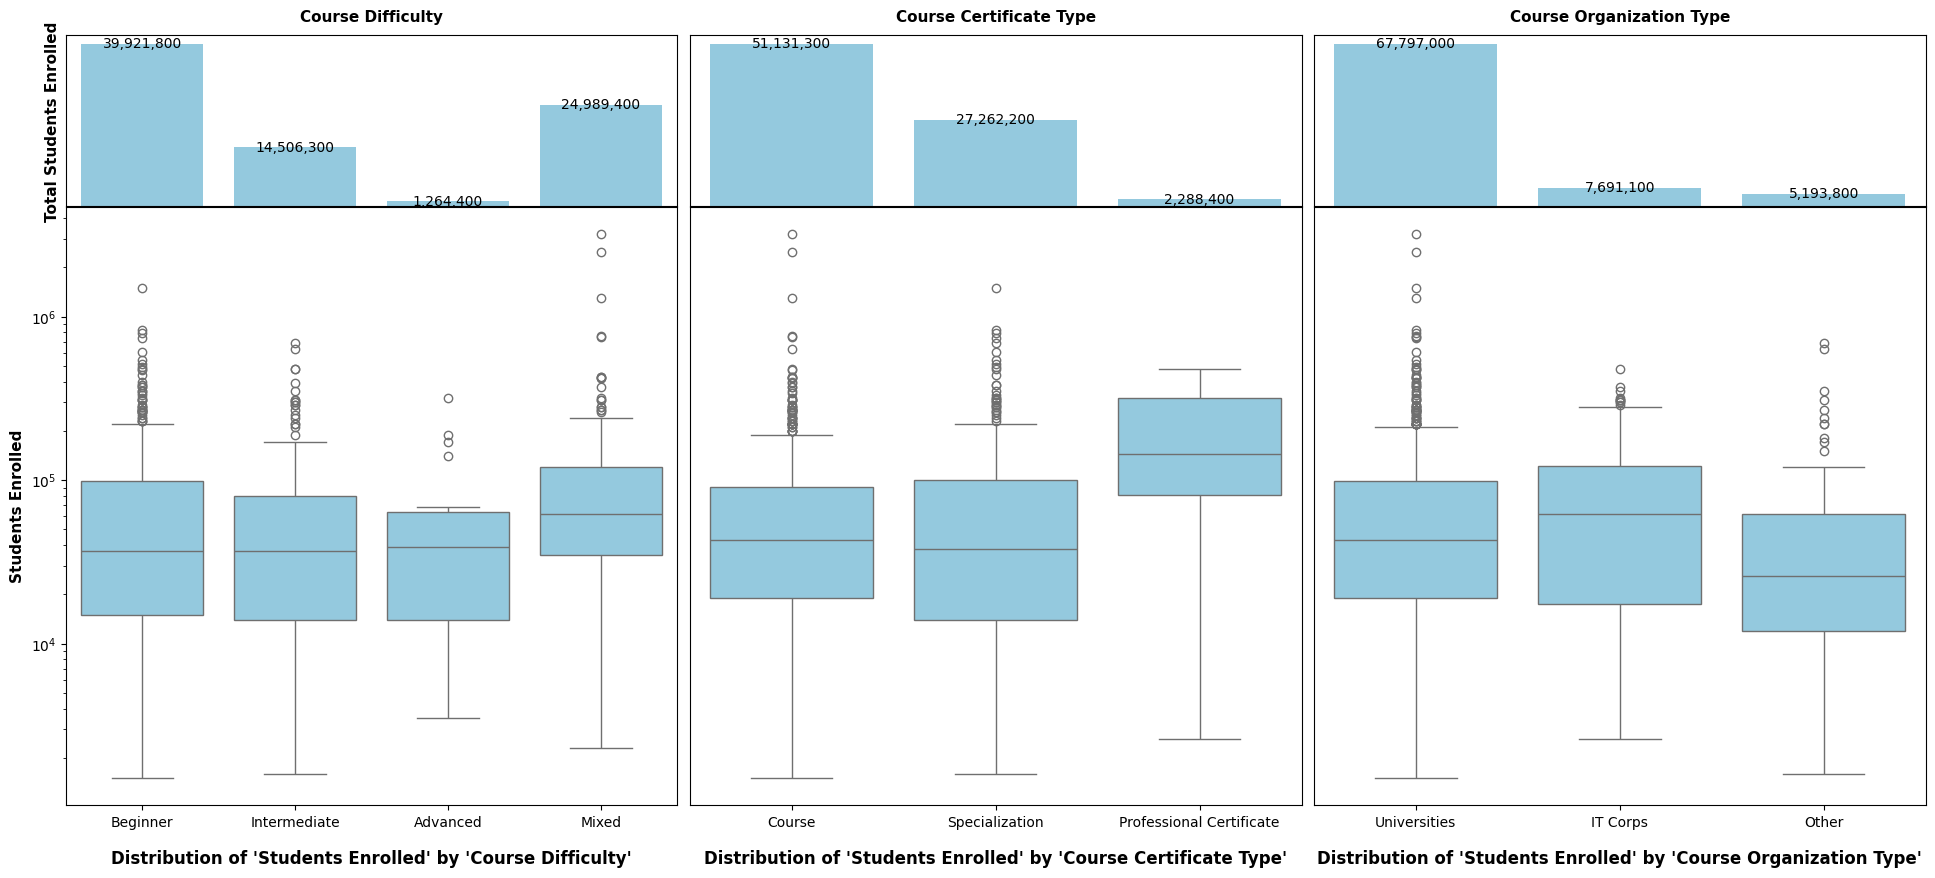

In [61]:
fig, axes = plt.subplots(
    2,
    len(CATEGORICAL_FEATURES),
    figsize=(len(CATEGORICAL_FEATURES) * 8, 10),
    gridspec_kw={"height_ratios": [1, 3.5]},
)

for idx, feature in enumerate(CATEGORICAL_FEATURES):
    feature_title = feature.replace("_", " ").title()

    ax_barplot = axes[0, idx]
    summed_data = (
        coursera_courses_df.groupby(feature, observed=True)["course_students_enrolled"]
        .sum()
        .reset_index()
    )
    barplot = sns.barplot(
        data=summed_data,
        x=feature,
        y="course_students_enrolled",
        ax=ax_barplot,
        color="skyblue",
    )

    for p in barplot.patches:
        barplot.annotate(
            "{:,}".format(int(p.get_height())),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            xytext=(0, -5),
            textcoords="offset points",
            color="black",
            fontsize=10,
        )
    barplot.set_title(feature_title, fontsize=11, fontweight="bold", pad=10)
    barplot.set_xlabel("")
    barplot.set_xticks([])
    barplot.set_yticks([])
    barplot.set_ylabel("Total Students Enrolled", fontsize=11, fontweight="bold")
    if idx != 0:
        barplot.yaxis.set_visible(False)
        barplot.set_ylabel("")

    ax_boxplot = axes[1, idx]
    boxplot = sns.boxplot(
        data=coursera_courses_df,
        x=feature,
        y="course_students_enrolled",
        ax=ax_boxplot,
        color="skyblue",
    )

    boxplot.set_xlabel(
        f"Distribution of 'Students Enrolled' by '{feature_title}'",
        fontsize=12,
        fontweight="bold",
        labelpad=15,
    )
    boxplot.set_ylabel("Students Enrolled", fontsize=11, fontweight="bold")
    boxplot.set_yscale("log")
    if idx != 0:
        boxplot.yaxis.set_visible(False)
        boxplot.set_ylabel("")

plt.subplots_adjust(hspace=0.001, wspace=0.02)

**Barplot and boxplot data overview:**
The y-axis of boxplot is adjusted using a log scale to provide a clearer view of the data distribution in the boxplot, as numerous outliers make the plot otherwise unreadable.
* Course Difficulty: All four categories ("Advanced", "Beginner", "Intermediate", "Mixed") have courses with similar popularity. The variance in the "Advanced" difficulty category is smaller than in the other groups though total sum of students are also much lower.

* Course Certificate Type: Although the "Professional Certificate" sample and total of students enrolled is the smallest, it is evident that more students choose these types of courses compared to "Course" or "Specialization" types. The "Course" and "Specialization" types have similar student enrollment rates, but both contain courses with exceptionally high numbers of enrolled students.

* Course Organization Type: The three categories ("Universities," "IT Corps," "Other") have courses with similar popularity, mirroring the pattern observed in the "Course Difficulty" feature.


The higher popularity mean of 'Professional Certificate' courses can be attributed to specific fields, such as IT, where specialists seek certifications to validate their expertise. The demand for these certifications is relatively stable, and the courses are more targeted, which also explains the absence of outliers.\
Similarly, the demand for 'Advanced' level courses is more consistent among specialists, maintaining a steady number of enrollments. Still the lower total of students enrolled and sample size in these categories could have an impact.

#### Distribution of 'Students Enrolled' by categorical features and 'Course Rating' variance

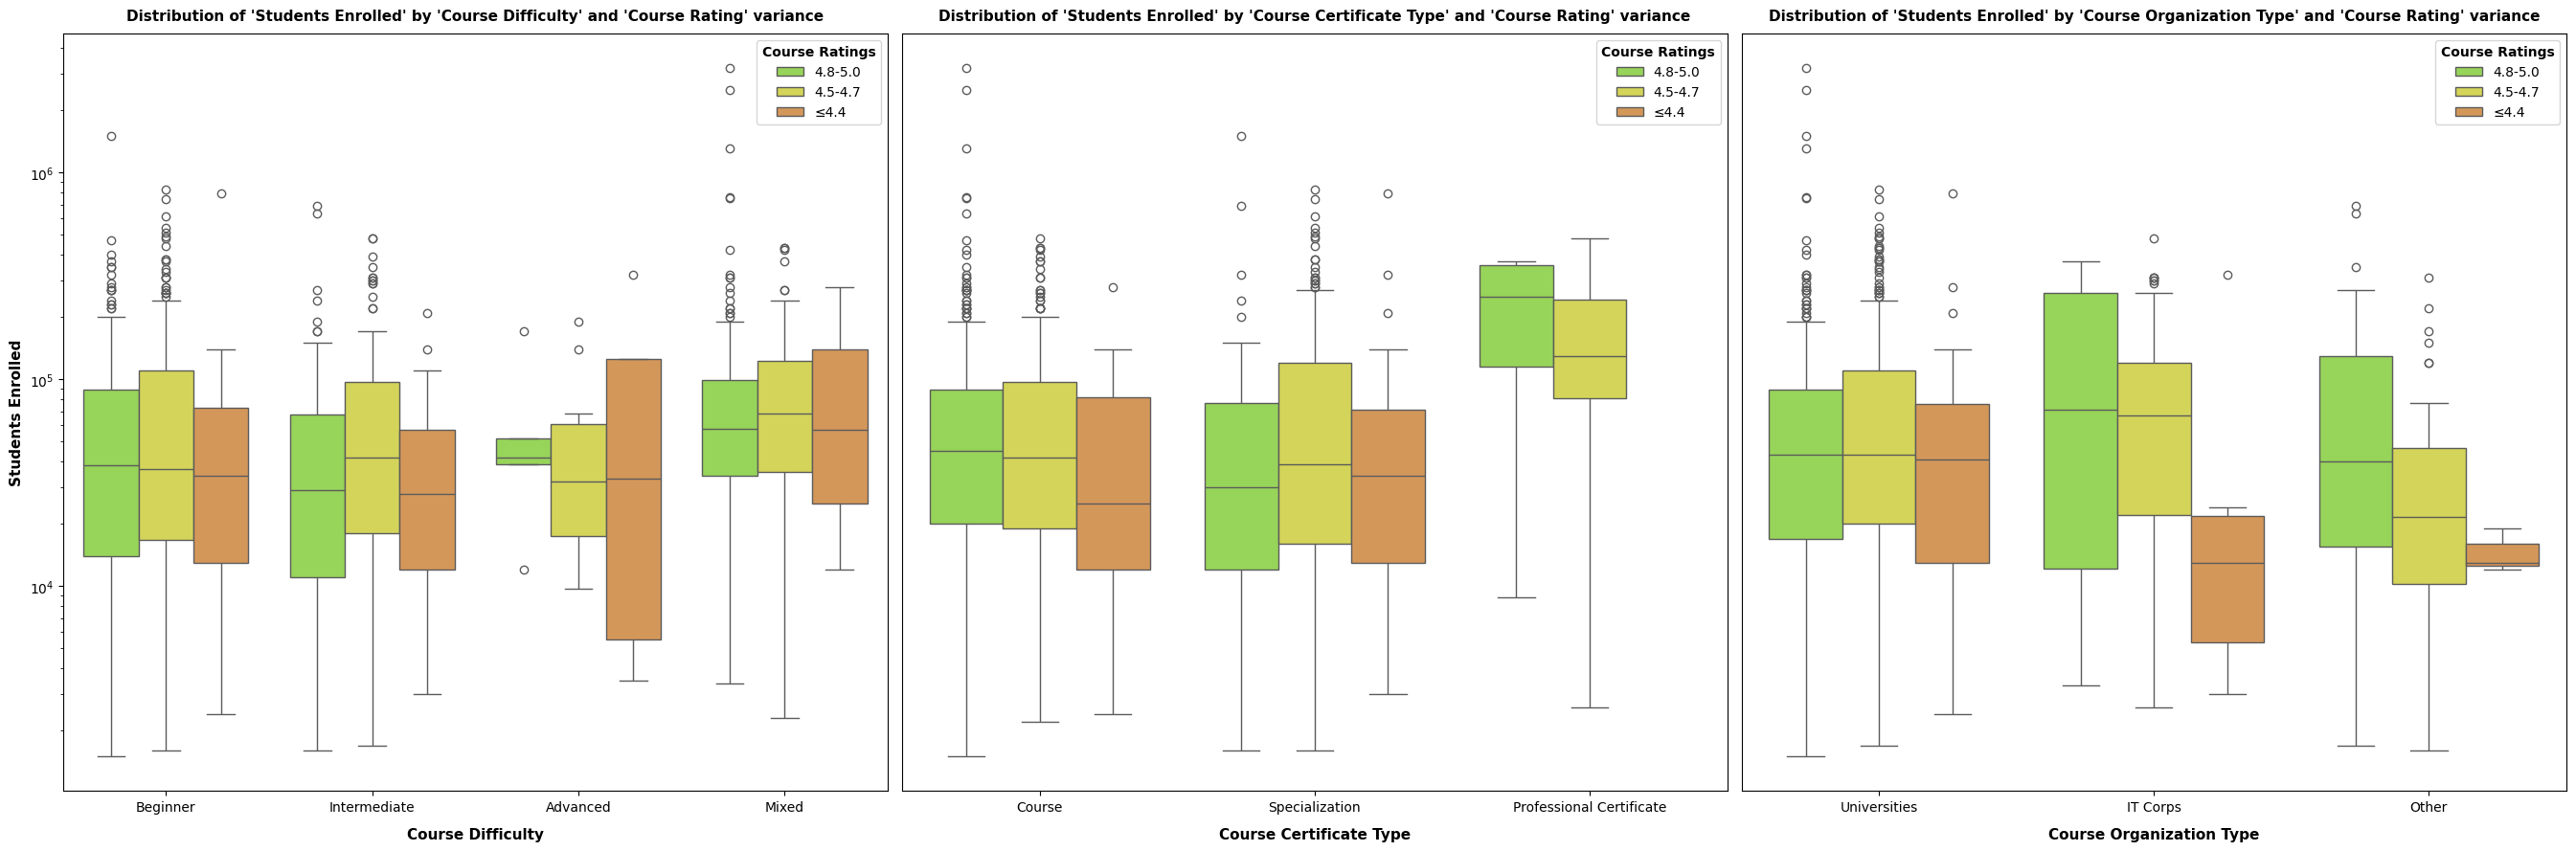

In [62]:
fig, axes = plt.subplots(
    1,
    TUPLE_LENGTH_OF_CATEGORICAL_FEATURES,
    figsize=(TUPLE_LENGTH_OF_CATEGORICAL_FEATURES * 9, 9),
)

for ax, feature in zip(axes, CATEGORICAL_FEATURES):
    feature_title = feature.replace("_", " ").title()

    boxplot = sns.boxplot(
        data=coursera_courses_df,
        x=feature,
        y="course_students_enrolled",
        hue="course_rating_binned",
        hue_order=GROUPS_ORDER_OF_COURSE_RATINGS,
        palette=GROUPS_PALETTE_OF_COURSE_RATINGS,
        ax=ax,
    )

    boxplot.set_title(
        f"Distribution of 'Students Enrolled' by '{feature_title}' and 'Course Rating' variance",
        fontsize=11,
        fontweight="bold",
        pad=10,
    )
    boxplot.set_xlabel(feature_title, fontsize=11, fontweight="bold", labelpad=10)
    boxplot.set_ylabel("Students Enrolled", fontsize=11, fontweight="bold")
    boxplot.set_yscale("log")
    if feature != CATEGORICAL_FEATURES[0]:
        boxplot.yaxis.set_visible(False)
        boxplot.set_ylabel("")
    boxplot.legend_.set_title(
        title="Course Ratings", prop={"size": 10, "weight": "bold"}
    )

fig.tight_layout()

**Boxplot data overview:**

The purpose of this graph is to examine how course popularity varies with different ratings. The expectation is that courses with lower ratings will have fewer enrollments, while those with higher ratings will be more popular. However, the graphs do not clearly show this trend. Apart from "IT Corps" and "Other" groups in "Course Organization Type" feature.

### Correlations between features

In [63]:
FEATURES_FOR_CORRELATION = [
    "course_certificate_type",
    "course_difficulty",
    "course_organization_type",
    "course_rating_binned",
    "course_students_enrolled",
]

corr_coursera_courses_df = coursera_courses_df[FEATURES_FOR_CORRELATION].copy()

I included features that are relevant for identifying correlations. Though, I tested whether including course titles, organization names, and course ratings (not binned) would yield any significant correlations, but none were found.

#### Checking normal distribution of "Course Students Enrolled" feature

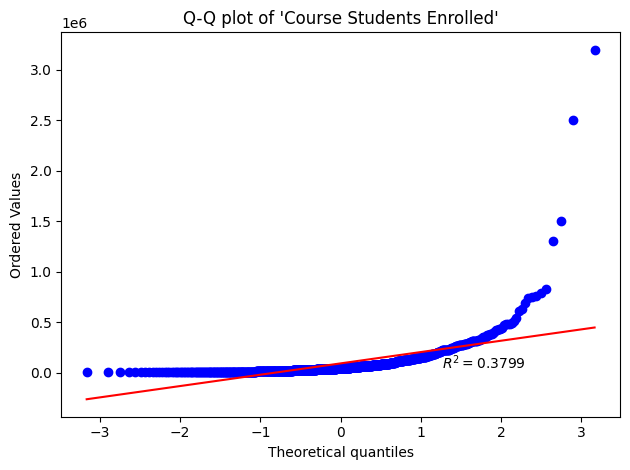

In [64]:
probplot(
    corr_coursera_courses_df["course_students_enrolled"],
    plot=plt,
    rvalue=True,  # the proportion of the variance in the dependent variable that is predictable from the independent variable
)
plt.title(f"Q-Q plot of 'Course Students Enrolled'")
plt.tight_layout()

Checked whether the 'Course Students Enrolled' data is normally distributed, and it is not. Therefore, it makes sense to use the Spearman Rank correlation, which is suitable for non-normally distributed features.

#### Heatmap of Spearman's rank correlation for the Coursera Course dataset

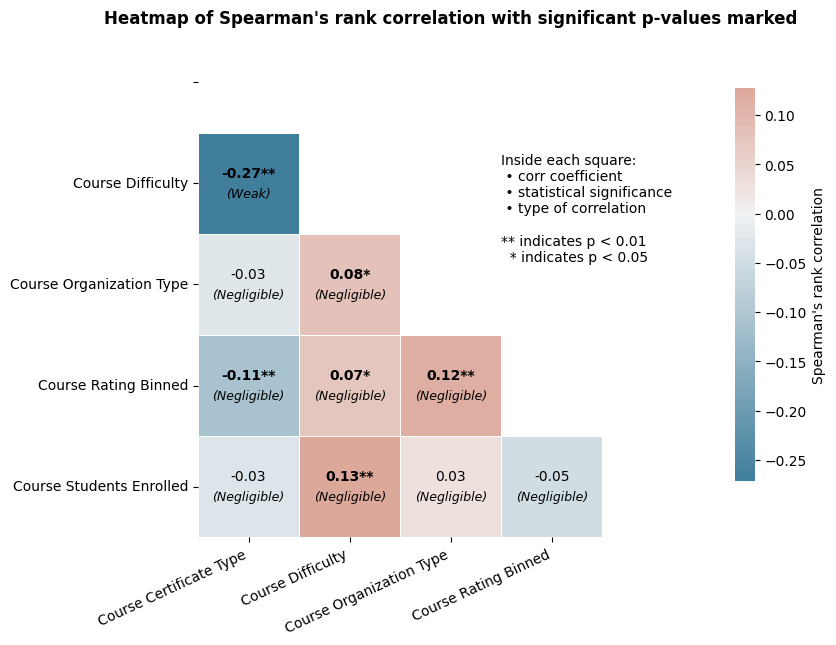

In [65]:
STRONG_SIGNIFICANT_EVIDENCE_THRESHOLD = 0.01
SIGNIFICANT_EVIDENCE_THRESHOLD = 0.05

STRONG_CORR_THRESHOLD = 0.4
MODERATE_CORR_THRESHOLD = 0.3
WEAK_CORR_THRESHOLD = 0.2

features_title_x_labels = corr_coursera_courses_df.columns.str.replace(
    "_", " "
).str.title()[:-1]
features_title_y_labels = (
    "",
    *corr_coursera_courses_df.columns.str.replace("_", " ").str.title()[1:],
)

corr_matrix, p_values_matrix = spearmanr(corr_coursera_courses_df)

plt.subplots(figsize=(8.5, 8.5))

upper_triangle_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    data=corr_matrix,
    mask=upper_triangle_mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5, "label": "Spearman's rank correlation"},
    xticklabels=features_title_x_labels,
    yticklabels=features_title_y_labels,
)

annotated_matrix = np.full_like(corr_matrix, "", dtype=object)

strong_significant_mask = p_values_matrix < STRONG_SIGNIFICANT_EVIDENCE_THRESHOLD
significant_mask = (
    p_values_matrix < SIGNIFICANT_EVIDENCE_THRESHOLD
) & ~strong_significant_mask
non_significant_mask = ~(strong_significant_mask | significant_mask)

annotated_matrix[strong_significant_mask] = np.char.add(
    np.char.mod("%.2f", corr_matrix[strong_significant_mask]), "**"
)
annotated_matrix[significant_mask] = np.char.add(
    np.char.mod("%.2f", corr_matrix[significant_mask]), "*"
)
annotated_matrix[non_significant_mask] = np.char.mod(
    "%.2f", corr_matrix[non_significant_mask]
)

# Annotate the heatmap with the correlation coefficients and p-values
for i in range(1, corr_matrix.shape[0]):
    for j in range(i):

        corr_value = corr_matrix[i, j]
        if abs(corr_value) >= STRONG_CORR_THRESHOLD:
            strength = "Strong"
        elif abs(corr_value) >= MODERATE_CORR_THRESHOLD:
            strength = "Moderate"
        elif abs(corr_value) >= WEAK_CORR_THRESHOLD:
            strength = "Weak"
        else:
            strength = "Negligible"
        plt.text(
            j + 0.5,
            i + 0.6,
            f"({strength})",
            ha="center",
            va="center",
            fontsize=9,
            fontstyle="italic",
        )

        annotation = annotated_matrix[i, j]
        if "**" in annotation:
            font_properties = {"size": 10, "weight": "bold"}
        elif "*" in annotation:
            font_properties = {"size": 10, "weight": "bold"}
        else:
            font_properties = {"size": 10}
        plt.text(
            j + 0.5, i + 0.4, annotation, ha="center", va="center", **font_properties
        )

plt.title(
    "Heatmap of Spearman's rank correlation with significant p-values marked",
    fontsize=12,
    fontweight="bold",
    loc="center",
)
plt.text(
    3,
    1.75,
    "Inside each square:\n • corr coefficient\n • statistical significance\n • type of correlation\n\n** indicates p < 0.01\n  * indicates p < 0.05",
    ha="left",
    va="center",
    fontsize=10,
)
plt.xticks(rotation=25, ha="right")
plt.tight_layout()

**Correlation heatmap data overview**

A weak negative correlation between "Course Difficulty" and "Course Certificate Type" was detected and is statistically significant. All other features exhibit negligible correlations.

The link to the Spearman's rank correlation coefficients:
https://www.researchgate.net/figure/Interpretation-Table-of-Spearman-Rank-Order-Correlation-Coefficients_tbl1_267339455

### Summary of exploratory data analysis

* Most courses are created by universities.

* "Professional Certificate" courses are rarer, but their attendance is higher compared to "Courses" and "Specializations".

* There is no clear trend that course popularity decreases with lower ratings.
    * "Advanced" level courses tend to receive more negative ratings, with a greater variation in lower ratings. It would be interesting to have more data to understand the reasons behind this trend.
        * Possible reason could be more critical students that are specialists of their fields.
* "Course Difficulty" and the number of existing courses has a relationship. There are more "Beginner" level courses than "Advanced" level courses.
    * Interestingly, the popularity of courses negligibly correlate with their difficulty. "Advanced" level courses can be as popular as "Beginner" level courses (excluding outliers).

## Suggestions for improved analysis

* I would create additional crosstab dataframes and display them as heatmaps to more clearly visualize the distributions of categorical data. Although the trend is already evident that most courses are designed for beginners and the number of courses decreases with increasing difficulty.